# California COVID-19 Hospitalizations

## Data sources

COVID-19: https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics

Population: https://data.ca.gov/dataset/california-population-projection-by-county-age-gender-and-ethnicity

In [1]:
import pandas as pd
from pathlib import Path

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

from ploomber import DAG
from ploomber.tasks import DownloadFromURL, PythonCallable
from ploomber.products import File

In [2]:
# matplotlib config
plt.style.use('ggplot')

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
mpl.rcParams['figure.dpi'] = 120

In [3]:
# we will save everything in data/
ROOT = Path('data/')
ROOT.mkdir(exist_ok=True)

In [4]:
# we use ploomber to get the organize our tasks
dag = DAG()

In [5]:
# first two tasks just download the data

SOURCE = 'https://data.chhs.ca.gov/dataset/6882c390-b2d7-4b9a-aefa-2068cee63e47/resource/6cd8d424-dfaa-4bdd-9410-a3d656e1176e/download/covid19data.csv'
download = DownloadFromURL(SOURCE, File(ROOT / 'raw.csv'), dag, name='raw')

SOURCE_POP = 'https://data.ca.gov/dataset/7a8c03d3-ed86-498a-acdb-8ea09ccb4130/resource/2c217b79-4625-4ab2-86b3-6fc5d66f0409/download/population-estimates-and-projections-by-county-age-and-sex-california-1970-2050.csv'
download_pop = DownloadFromURL(SOURCE_POP, File(
    ROOT / 'raw_pop'), dag, name='raw_pop')

In [6]:
# we then join the downloaded data to normalize using population by county
def _join(upstream, product):
    """Join California COVID-19 hospitalizations with population data
    """
    df = pd.read_csv(str(upstream['raw']))

    df['Most Recent Date'] = pd.to_datetime(df['Most Recent Date'])
    idx_m_recent = df.groupby('County Name')['Most Recent Date'].idxmax()
    m_recent_total = df.iloc[idx_m_recent][['Most Recent Date', 'County Name',
                                            'Total Count Confirmed']]
    m_recent_total['county'] = m_recent_total['County Name'].str.upper()

    pop = pd.read_csv(str(upstream['raw_pop']))
    pop_by_county = pop[pop.year == 2020].groupby('county')[
        ['pop_total']].sum()
    m_recent = pop_by_county.merge(m_recent_total, on='county')
    m_recent['Total count per 100k population'] = (m_recent['Total Count Confirmed']
                                                   / m_recent['pop_total'] * 100_000)
    m_recent.to_csv(str(product), index=False)

In [7]:
join = PythonCallable(_join, File(ROOT / 'joined.csv'), dag, name='joined')

# the joined data depends on the raw data
(download + download_pop) >> join

PythonCallable: joined -> File(data/joined.csv)

In [8]:
# summary table
dag.status()

name,type,status,client,Last updated,Outdated?,Outdated dependencies,Outdated code,Product type,Product,Product client,Doc (short),Location
raw,DownloadFromURL,WaitingExecution,None,Has not been run,Source code,False,True,File,data/raw.csv,,,
raw_pop,DownloadFromURL,WaitingExecution,None,Has not been run,Source code,False,True,File,data/raw_pop,,,
joined,PythonCallable,WaitingUpstream,None,Has not been run,Source code & Upstream,True,True,File,data/joined.csv,,Join California COVID-19 hospitalizations with population data,:2


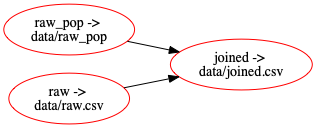

In [9]:
# plot. NOTE: pygraphviz is required to plot, easiest way to install is via "conda install pygraphviz"
path = dag.plot()
Image(filename=path)

In [10]:
# run all tasks
dag.build()

name,Ran?,Elapsed (s),Percentage
raw_pop,True,2.87552,69.5553
raw,True,0.791171,19.1374
joined,True,0.46746,11.3073


In [11]:
# load joined data
m_recent = pd.read_csv(str(dag['joined']))

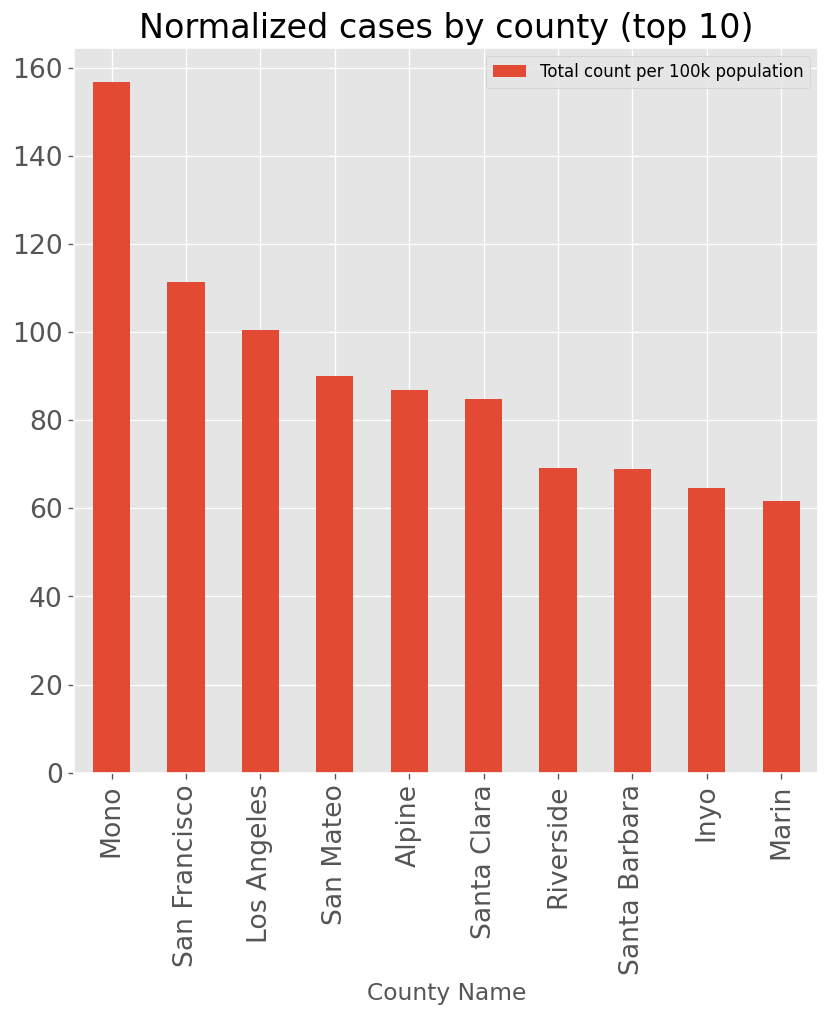

In [12]:
(m_recent[['County Name', 'Total count per 100k population']]
 .set_index('County Name')
 .sort_values(by='Total count per 100k population', ascending=False)
 .head(10)
 .plot(kind='bar', title='Normalized cases by county (top 10)'))